In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [3]:
# number of iterations
num_iters = 2100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████████████████████████████████████████████████████████████████████████| 2100/2100 [03:39<00:00,  9.56it/s]


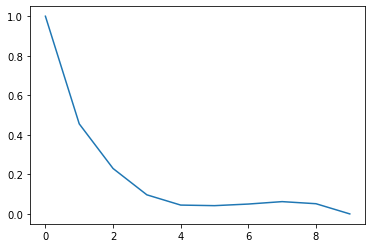

In [4]:
# Code for plotting the autocorrelation function for player p
p = 5
autocor = np.zeros(10)
for i in range(10):
    autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
plt.plot(autocor)

# Problem (a)

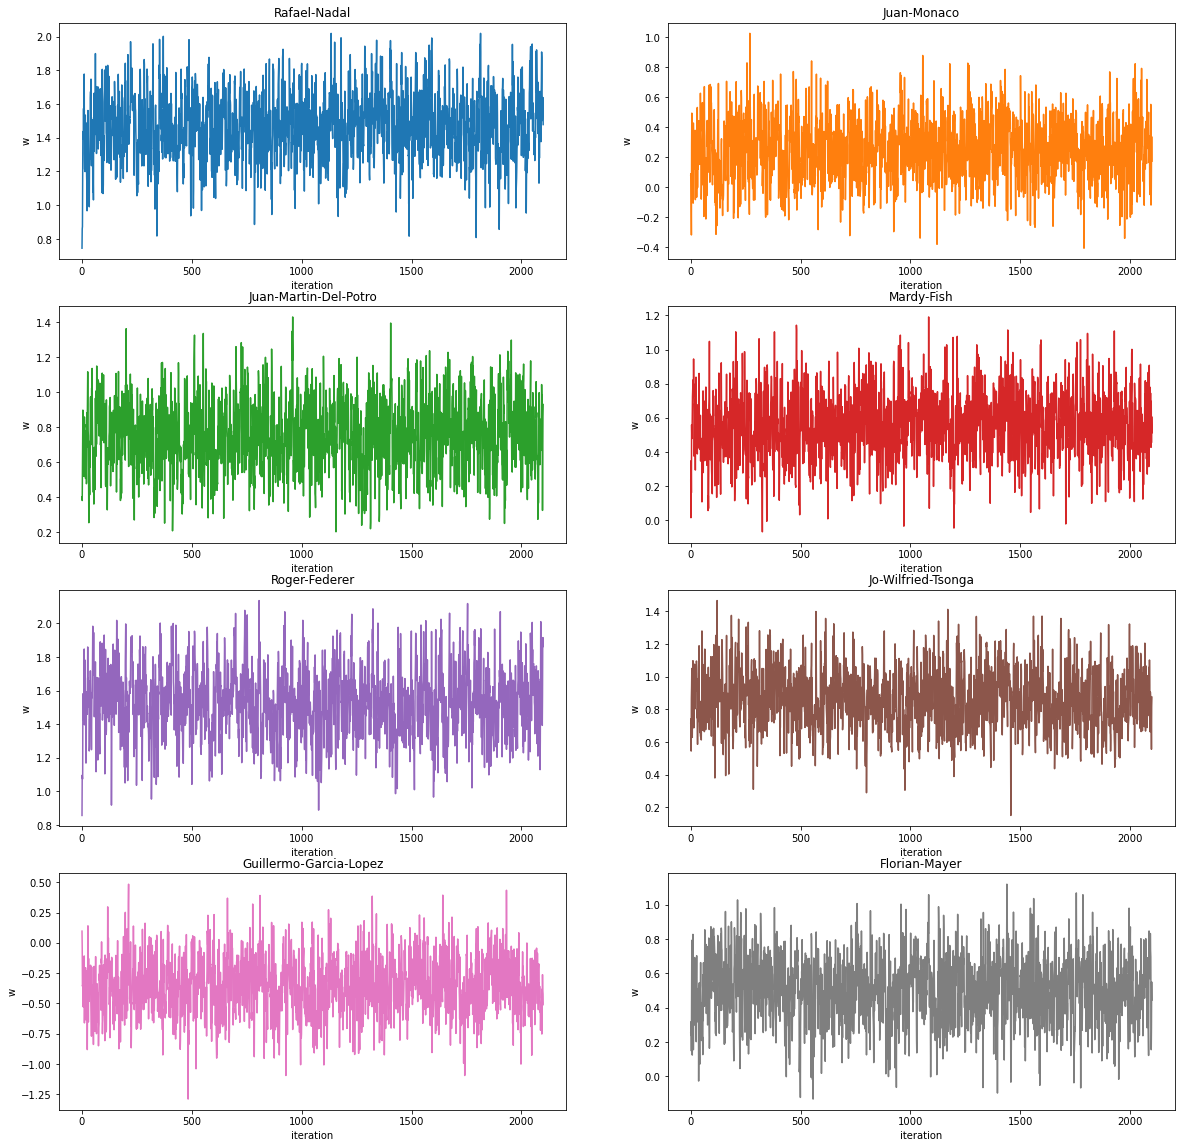

In [5]:
# select 6 members randomly and plot their trace plot for all 1100 iterations
player_index = [0,1,2,3,4,5,6,7]
fig, axs = plt.subplots(4,2,figsize=(20,20))
for i in range(4):
    for j in range(2):
        axs[i,j].plot(skill_samples[player_index[2*i+j],:],color='C'+str(2*i+j))
        axs[i,j].set_title(W[player_index[2*i+j]][0])
        axs[i,j].set_ylabel("w")
        axs[i,j].set_xlabel("iteration")

plt.savefig("problem_a_1100_gibbs.pdf")

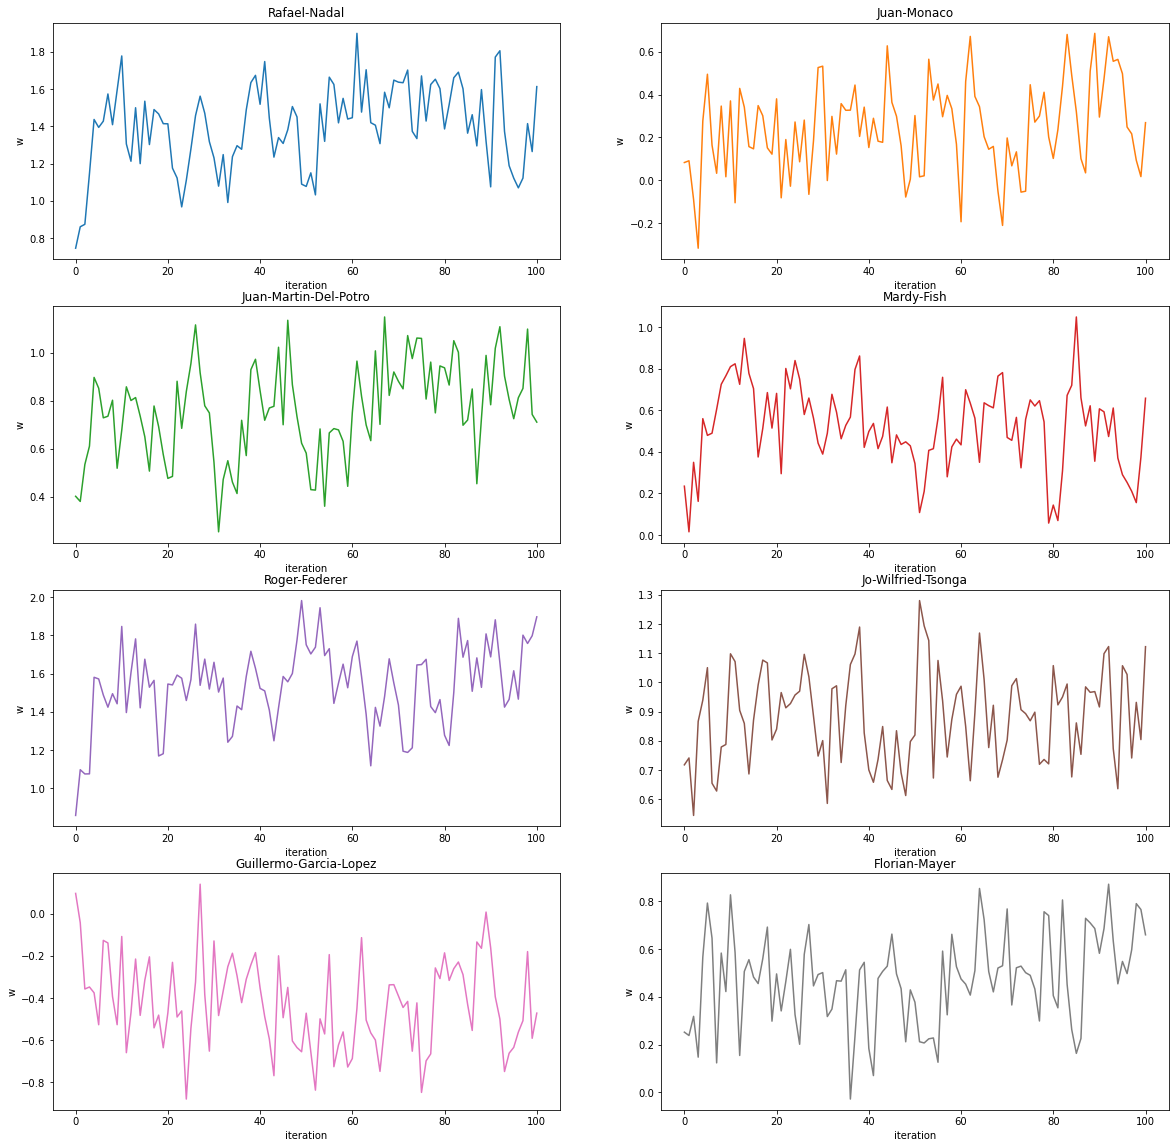

In [6]:
# Code for first 100 iteration
fig, axs = plt.subplots(4,2,figsize=(20,20))
for i in range(4):
    for j in range(2):
        axs[i,j].plot(skill_samples[player_index[2*i+j],:][0:101],color='C'+str(2*i+j))
        axs[i,j].set_title(W[player_index[2*i+j]][0])
        axs[i,j].set_ylabel("w")
        axs[i,j].set_xlabel("iteration")

plt.savefig("problem_a_100_gibbs.pdf")

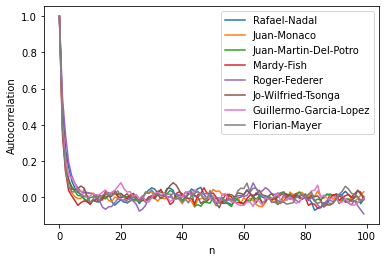

In [7]:
# Autocorrelation plot
for n,p in enumerate(player_index):
    autocor = np.zeros(100)
    for i in range(100):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
    plt.plot(autocor,label=W[player_index[n]][0])
plt.legend(list(W[list(player_index)].reshape(-1,)))
plt.xlabel("n")
plt.ylabel("Autocorrelation")

plt.savefig("problem_a_autocorr.pdf")

In [8]:
# Autocorrelation time calculation
Autocor = np.zeros((107,100))
for a in range(107):
    autocor = np.zeros(100)
    for i in range(100):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[a,:]),lag=i)
    Autocor[a] = autocor

Autocor_time = (2*Autocor.sum(1)-1).max()

In [35]:
Autocor_time

9.432355556103996

# EP ranking

In [10]:
num_iters = 3
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

# Problem (b)

In [11]:
# 100 iterations of EP
num_iters = 100
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

In [12]:
# For loop, output mean and precision skills in each of the 100 iterations.
mean_player = []
precision_player = []
for i in range(1,101):
    mean_player_skills, precision_player_skills = eprank(G, M, i)
    mean_player.append(mean_player_skills)
    precision_player.append(precision_player_skills)

mean_player = np.array(mean_player)
precision_player = np.array(precision_player)

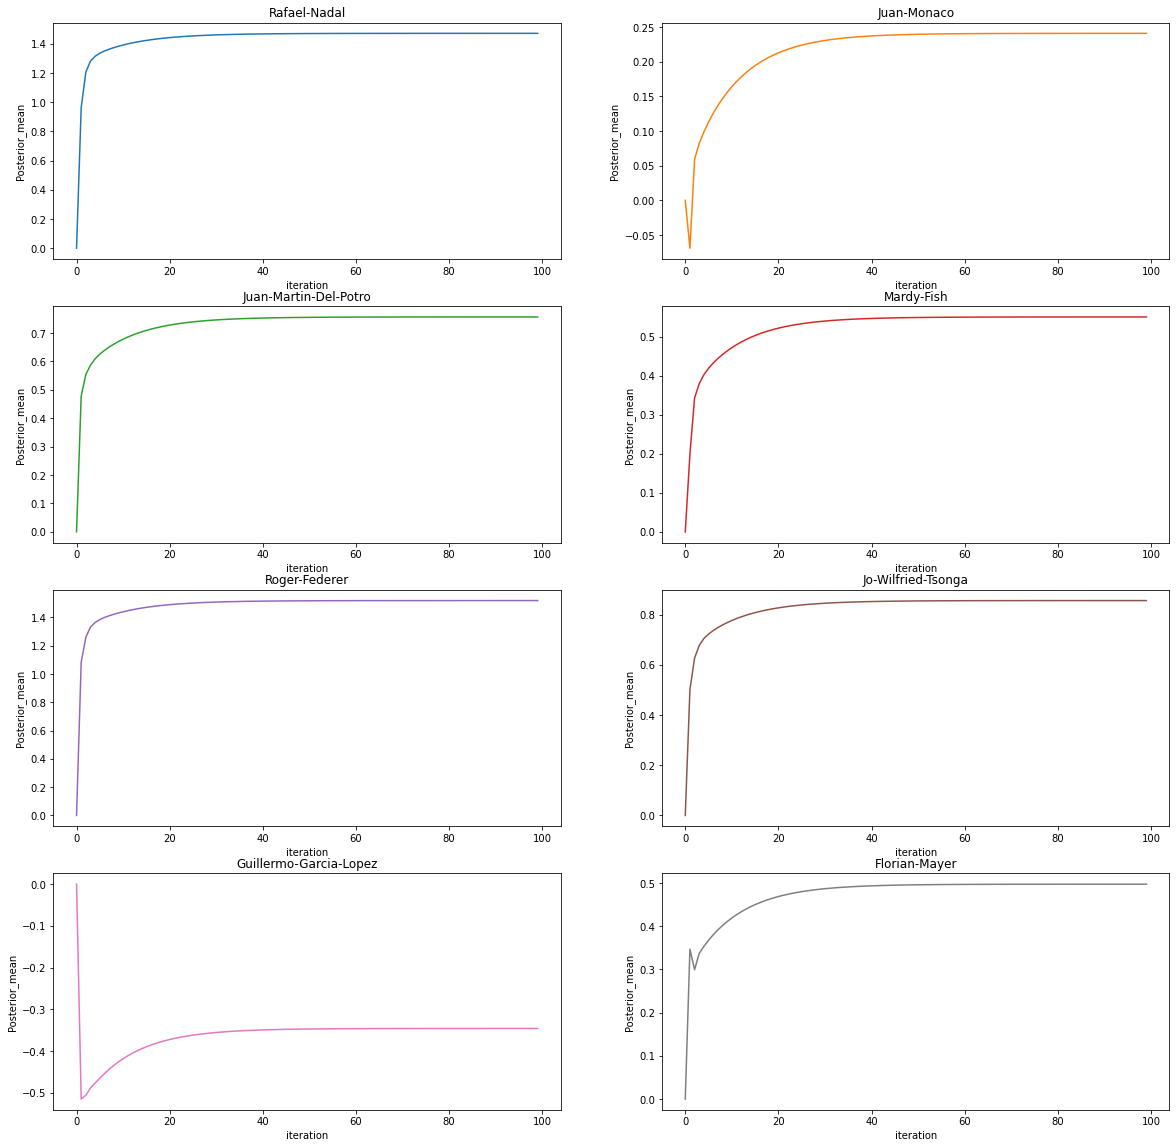

In [13]:
# Code for Posterior mean plots of the 100 iteratons of EP for the first 8 players on the lsit
fig, axs = plt.subplots(4,2,figsize=(20,20))
for i in range(4):
    for j in range(2):
        axs[i,j].plot(mean_player[:,player_index[2*i+j]][0:101],color='C'+str(2*i+j))
        axs[i,j].set_title(W[player_index[2*i+j]][0])
        axs[i,j].set_ylabel("Posterior_mean")
        axs[i,j].set_xlabel("iteration")

plt.savefig("problem_b_mean.pdf")

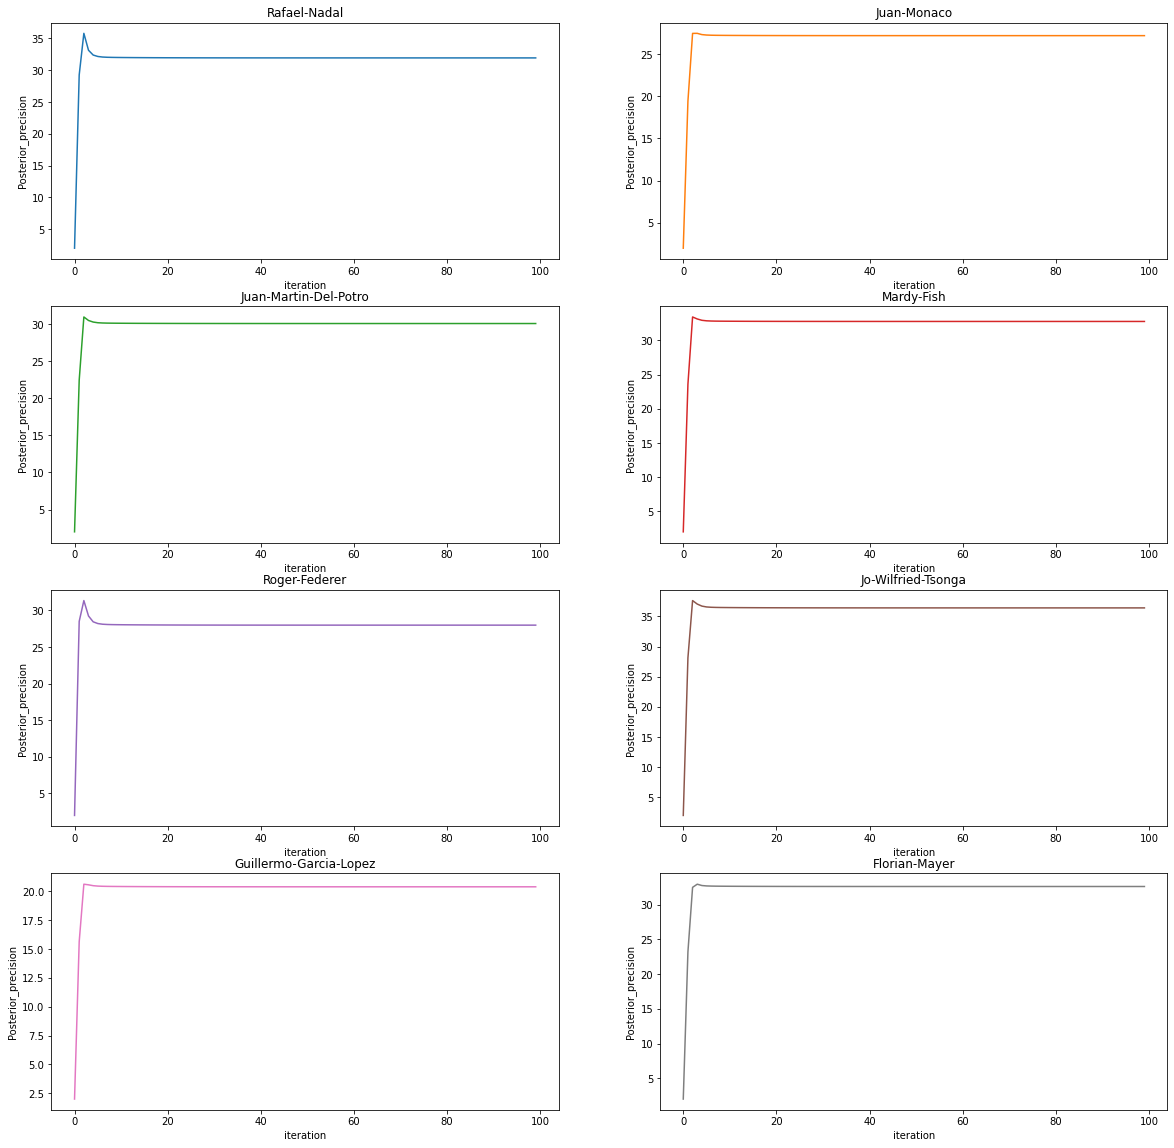

In [14]:
# Code for Posterior precision plots of the 100 iteratons of EP for the first 8 players on the lsit
fig, axs = plt.subplots(4,2,figsize=(20,20))
for i in range(4):
    for j in range(2):
        axs[i,j].plot(precision_player[:,player_index[2*i+j]][0:101],color='C'+str(2*i+j))
        axs[i,j].set_title(W[player_index[2*i+j]][0])
        axs[i,j].set_ylabel("Posterior_precision")
        axs[i,j].set_xlabel("iteration")

plt.savefig("problem_b_precision.pdf")

# Problem (c)

In [15]:
# Code for find index of the top 4 player.
import scipy
top_4_index = []
for i in ["Novak-Djokovic","Rafael-Nadal","Roger-Federer","Andy-Murray"]:
    top_4_index.append(np.where(W==i)[0].item())

# Probability that the skill of one player is higher than the other for the top 4 players
skill_prob = np.zeros([4,4])
for i in range(4):
    for j in range(4):
        skill_prob[i,j] = 1-scipy.stats.norm.cdf(0,mean_player[-1,top_4_index[i]]-mean_player[-1,top_4_index[j]],np.sqrt(1/precision_player[-1,top_4_index[i]]+1/precision_player[-1,top_4_index[j]]))

# Probability that one player is beating the other for the top 4 players.
winning_prob=np.zeros([4,4])
for i in range(4):
    for j in range(4):
        winning_prob[i,j] = 1-scipy.stats.norm.cdf(0,mean_player[-1,top_4_index[i]]-mean_player[-1,top_4_index[j]],np.sqrt(1/precision_player[-1,top_4_index[i]]+1/precision_player[-1,top_4_index[j]]+1))

In [16]:
skill_prob

array([[0.5       , 0.93982221, 0.90888527, 0.98532149],
       [0.06017779, 0.5       , 0.42717016, 0.7665184 ],
       [0.09111473, 0.57282984, 0.5       , 0.81083525],
       [0.01467851, 0.2334816 , 0.18916475, 0.5       ]])

In [17]:
winning_prob

array([[0.5       , 0.65536705, 0.63802697, 0.71982569],
       [0.34463295, 0.5       , 0.4816481 , 0.57310992],
       [0.36197303, 0.5183519 , 0.5       , 0.59087902],
       [0.28017431, 0.42689008, 0.40912098, 0.5       ]])

In [37]:
1-scipy.stats.norm.cdf(0,mean_player[-1,top_4_index[1]]-mean_player[-1,top_4_index[0]],np.sqrt(1/precision_player[-1,top_4_index[1]]+1/precision_player[-1,top_4_index[0]]+1))

0.34463295391712867

In [38]:
scipy.stats.norm.cdf((mean_player[-1,top_4_index[1]]-mean_player[-1,top_4_index[0]])/(np.sqrt(1/precision_player[-1,top_4_index[1]]+1/precision_player[-1,top_4_index[0]]+1)))

0.34463295391712867

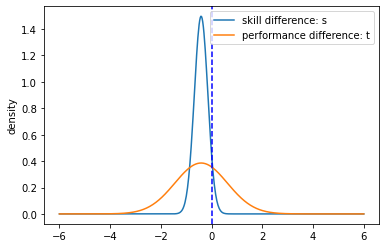

In [18]:
plt.plot(np.linspace(-6,6,500),scipy.stats.norm.pdf(np.linspace(-6,6,500), mean_player[-1,top_4_index[1]]-mean_player[-1,top_4_index[0]],
                             np.sqrt(1/precision_player[-1,top_4_index[1]]+1/precision_player[-1,top_4_index[0]])),label="skill difference: s")
plt.plot(np.linspace(-6,6,500),scipy.stats.norm.pdf(np.linspace(-6,6,500), mean_player[-1,top_4_index[1]]-mean_player[-1,top_4_index[0]],
                             np.sqrt(1/precision_player[-1,top_4_index[1]]+1/precision_player[-1,top_4_index[0]]+1)),label="performance difference: t")

plt.axvline(x = 0, color = 'b',linestyle='dashed')
plt.ylabel("density")
plt.legend()
plt.savefig('problem_c.pdf')


# Problem (d)


In [19]:
# Discard first 10 samples 
skill_samples_top_4 = skill_samples[top_4_index][:,10:]

In [20]:
## Using 2 marginal Gaussian for approximating marginal skills of Nadall and Djokovic
# For Nadal:
mean_Nadal = np.mean(skill_samples_top_4[1])
var_Nadal = np.var(skill_samples_top_4[1])
# For Djokovic：
mean_Djokovic = np.mean(skill_samples_top_4[0])
var_Djokovic = np.var(skill_samples_top_4[0],ddof=0)

print(mean_Nadal,mean_Djokovic,var_Nadal,var_Djokovic)
# Compute P(Nadal skill > Djokovic skill)
P_marginal = 1 - scipy.stats.norm.cdf(0,mean_Nadal-mean_Djokovic,np.sqrt(var_Nadal+var_Djokovic))
P_marginal

1.4668330122849267 1.900407975248704 0.037844098162088266 0.047093700495094745


0.06841576753060463

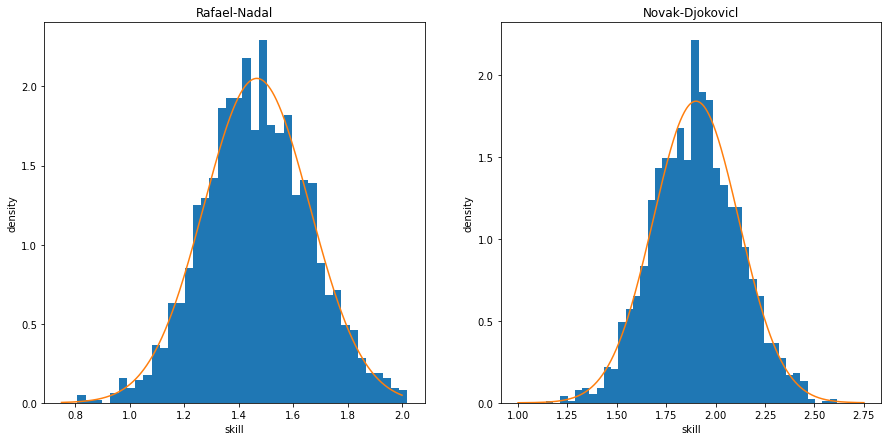

In [21]:
# Plot of 2 gaussian density plot 
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].hist(skill_samples_top_4[1],bins=40,density=True)
ax[0].plot(np.linspace(0.75,2,500),scipy.stats.norm.pdf(np.linspace(0.75,2,500),mean_Nadal,np.sqrt(var_Nadal)))
ax[0].set_title("Rafael-Nadal")
ax[0].set_xlabel("skill")
ax[0].set_ylabel("density")

ax[1].hist(skill_samples_top_4[0],bins=40,density=True)
ax[1].plot(np.linspace(1,2.75,500),scipy.stats.norm.pdf(np.linspace(1,2.75,500),mean_Djokovic,np.sqrt(var_Djokovic)))
ax[1].set_title("Novak-Djokovicl")
ax[1].set_xlabel("skill")
ax[1].set_ylabel("density")

plt.savefig("problem_d_mar.pdf")

In [22]:
## Using one Gaussian for approximating joint skills of Nadal and Djokovic
mean_joint = np.mean(skill_samples_top_4[[0,1]],axis=1)
cov_mat = np.cov(skill_samples_top_4[[0,1]],ddof=0)
# Compute P(Nadal skill > Djokovic skill)
print(mean_joint,cov_mat)
P_joint = 1-scipy.stats.norm.cdf(0,mean_joint[1]-mean_joint[0],np.sqrt(cov_mat[0,0]+cov_mat[1,1]-2*cov_mat[0,1]))
P_joint

[1.90040798 1.46683301] [[0.0470937 0.0099793]
 [0.0099793 0.0378441]]


0.04448154290935258

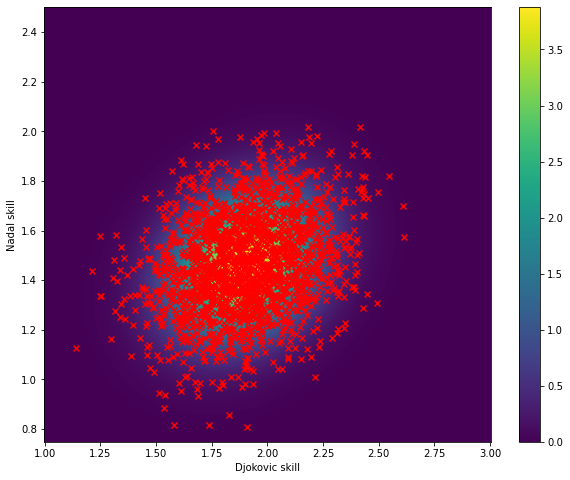

In [23]:
## plot the joint Gaussian density
xi,yi = np.meshgrid(np.linspace(1,3,500),np.linspace(0.75,2.5,500))
pos = np.dstack((xi, yi))
zi = scipy.stats.multivariate_normal.pdf(pos,mean_joint,cov_mat)
plt.figure(figsize=(10,8))
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.scatter(skill_samples_top_4[0],skill_samples_top_4[1],marker="x",color="r")
plt.xlabel("Djokovic skill")
plt.ylabel("Nadal skill")
#plt.savefig("problem_d_joint.pdf")
plt.savefig("problem_d_joint.png",dpi=80)

In [24]:
## Using the data directly, discard the first 10 samples
# Compute P(Nadal skill > Djokovic skill)
P_direct = np.mean(skill_samples_top_4[1]>skill_samples_top_4[0])
P_direct

0.04401913875598086

In [25]:
## 4*4 matrix of skill difference using direct 
P_skills_gibbs = np.zeros([4,4])
for i in range(4):
    for j in range(4):
        P_skills_gibbs[i,j] = np.mean(skill_samples_top_4[i]>skill_samples_top_4[j])

In [26]:
P_skills_gibbs

array([[0.        , 0.95598086, 0.91674641, 0.9861244 ],
       [0.04401914, 0.        , 0.39090909, 0.76028708],
       [0.08325359, 0.60909091, 0.        , 0.81004785],
       [0.0138756 , 0.23971292, 0.18995215, 0.        ]])

# Problem (e)

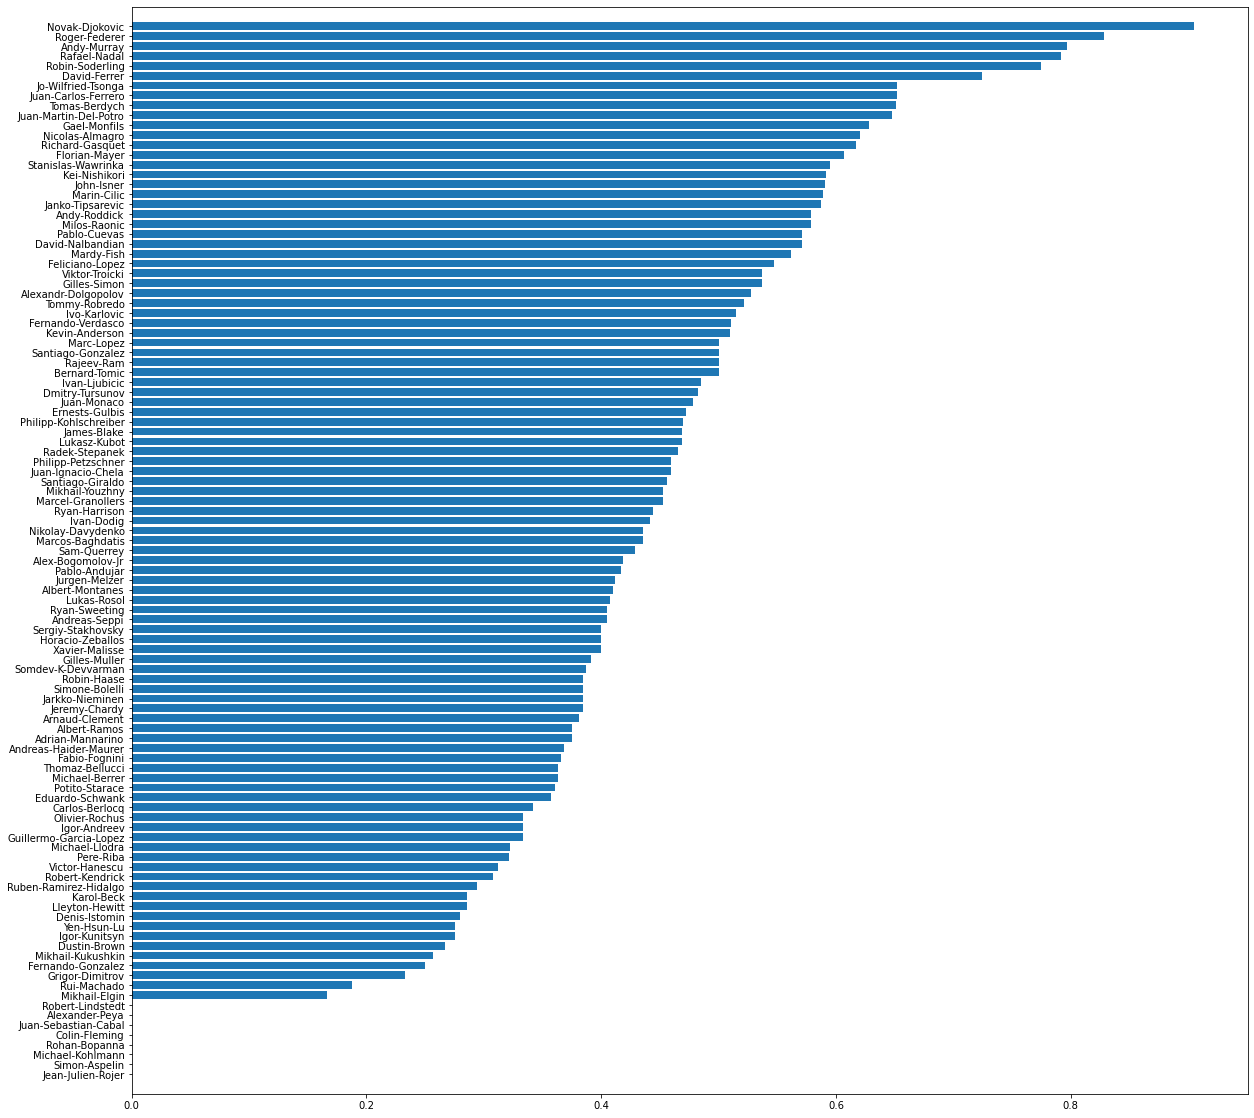

In [27]:
# empirical game outcome averages
P_empirical = np.zeros(107)
for i in range(107):
    P_empirical[i] = np.sum(G[:,0]==i)/(np.sum(G[:,0]==i)+np.sum(G[:,1]==i))

sorted_barplot(P_empirical,W)

In [28]:
# Gibbs sampling predictions discarding the first 10 samples from the gibbs sampler
Gibbs_outcome = np.zeros((107,107))
skill_samples_burn_in = skill_samples[:,10:]
for i in range(107):
    for j in range(107):
        if i!=j:
            Gibbs_outcome[i,j] = np.mean(scipy.stats.norm.cdf(skill_samples_burn_in[i]-skill_samples_burn_in[j]))
        elif i==j:
            Gibbs_outcome[i,j] = 0

P_Gibbs = np.sum(Gibbs_outcome,axis=1)/106


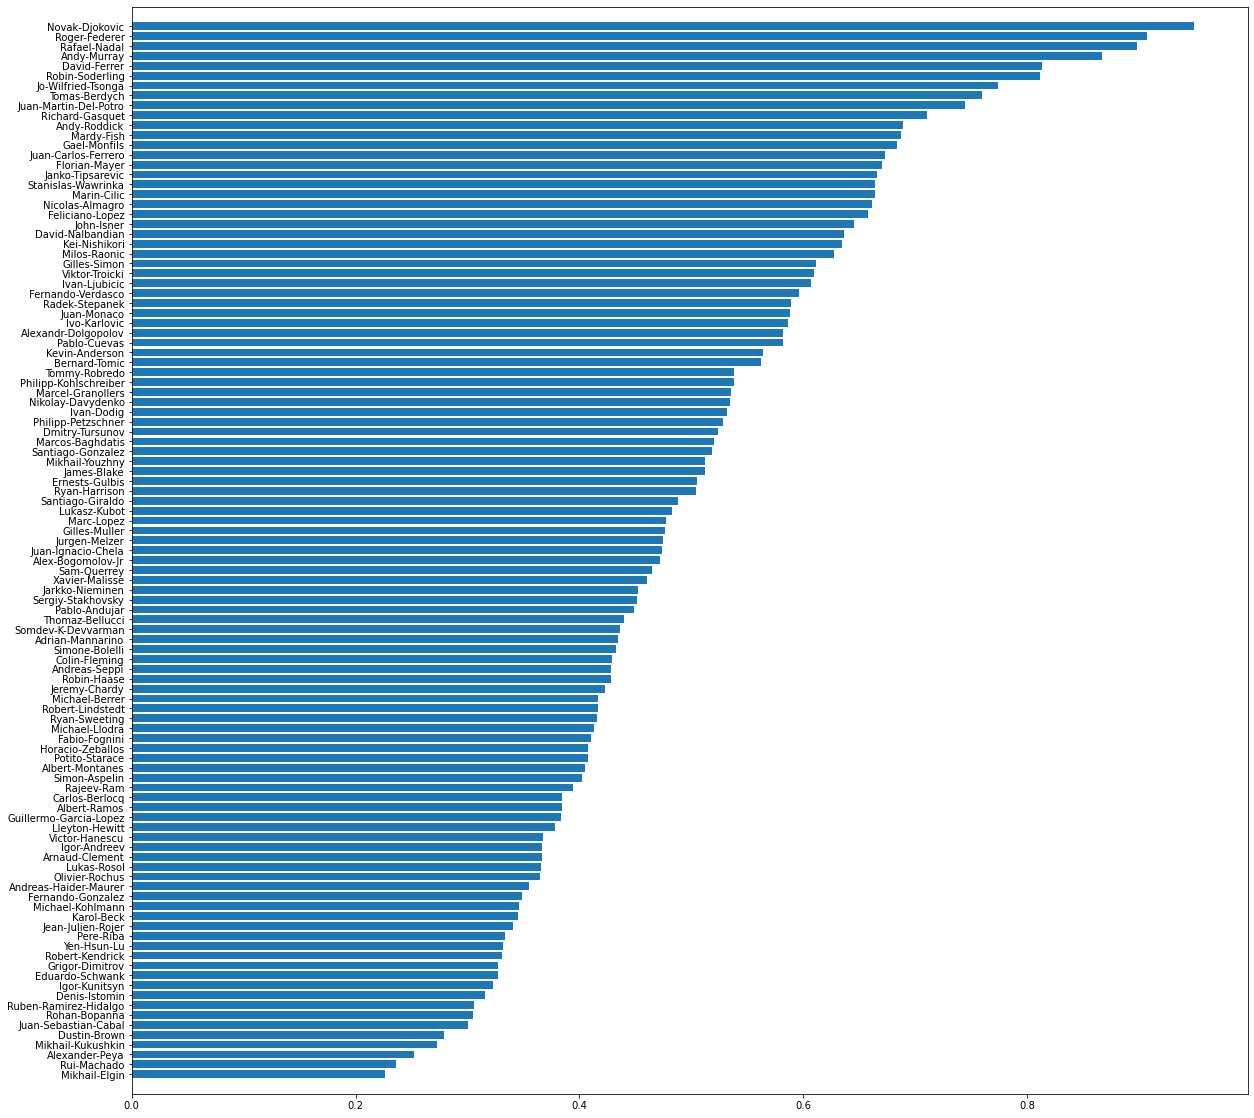

In [29]:
sorted_barplot(P_Gibbs,W)

In [30]:
# message passing predictions
MP_outcome = np.zeros((107,107))
for i in range(107):
    for j in range(107):
        if i!=j:
            MP_outcome[i,j] = 1-scipy.stats.norm.cdf(0,mean_player[-1,i]-mean_player[-1,j],np.sqrt(1/precision_player[-1,i]+1/precision_player[-1,j]+1))
        elif i==j:
            MP_outcome[i,j] = 0

P_MP = np.sum(MP_outcome,axis=1)/106

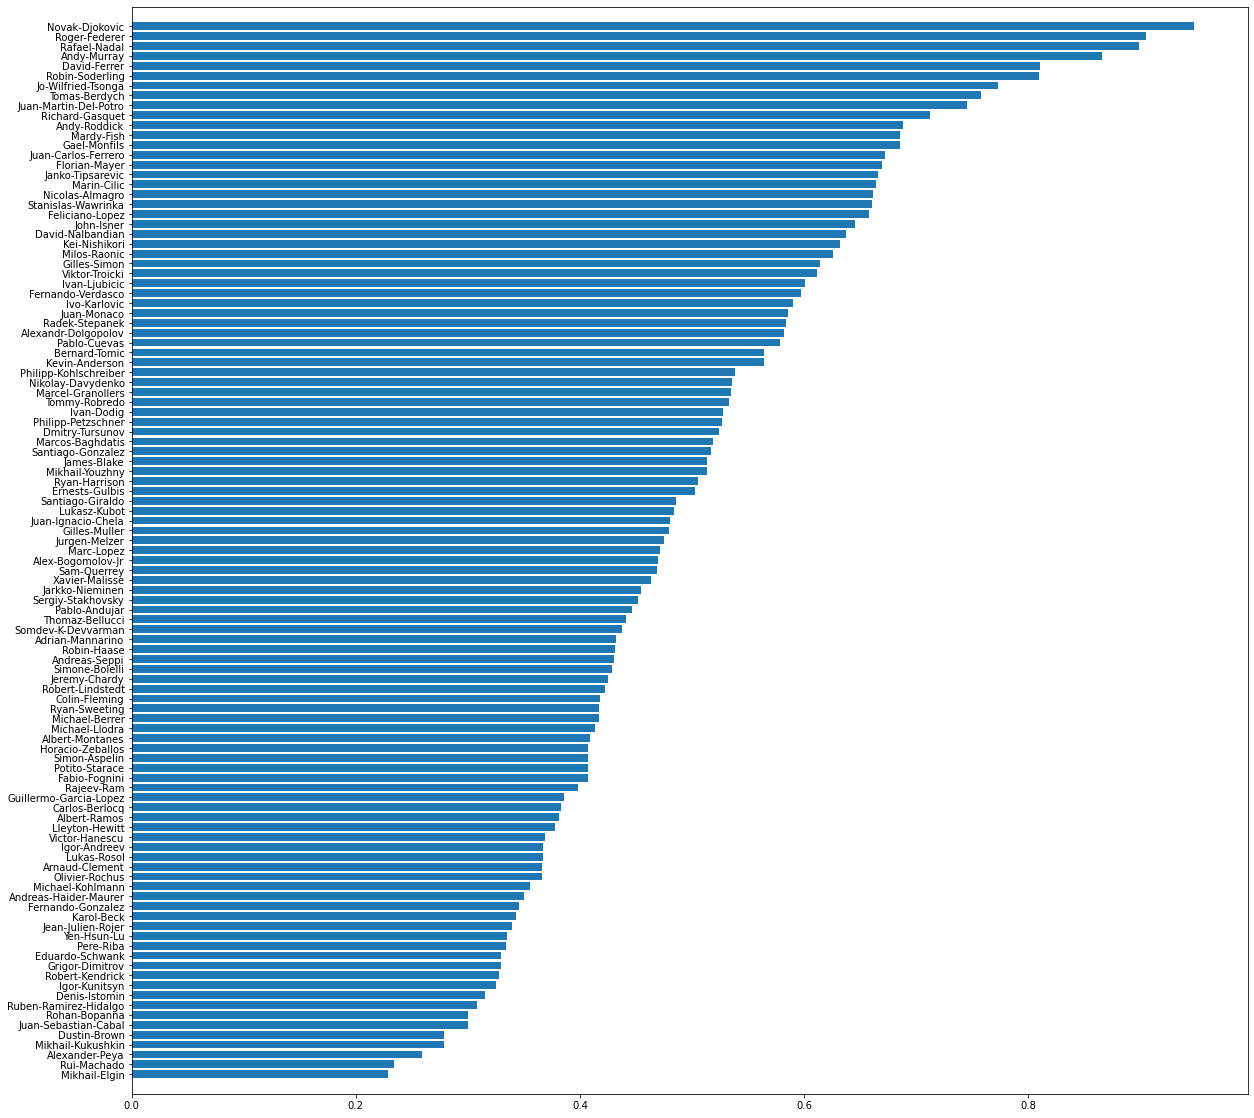

In [31]:
sorted_barplot(P_MP,W)

In [32]:
np.flip(W.flatten()[P_Gibbs.argsort()])[:20]

array(['Novak-Djokovic', 'Roger-Federer', 'Rafael-Nadal', 'Andy-Murray',
       'David-Ferrer', 'Robin-Soderling', 'Jo-Wilfried-Tsonga',
       'Tomas-Berdych', 'Juan-Martin-Del-Potro', 'Richard-Gasquet',
       'Andy-Roddick', 'Mardy-Fish', 'Gael-Monfils',
       'Juan-Carlos-Ferrero', 'Florian-Mayer', 'Janko-Tipsarevic',
       'Stanislas-Wawrinka', 'Marin-Cilic', 'Nicolas-Almagro',
       'Feliciano-Lopez'], dtype=object)

In [33]:
np.flip(W.flatten()[P_MP.argsort()])[:20]

array(['Novak-Djokovic', 'Roger-Federer', 'Rafael-Nadal', 'Andy-Murray',
       'David-Ferrer', 'Robin-Soderling', 'Jo-Wilfried-Tsonga',
       'Tomas-Berdych', 'Juan-Martin-Del-Potro', 'Richard-Gasquet',
       'Andy-Roddick', 'Mardy-Fish', 'Gael-Monfils',
       'Juan-Carlos-Ferrero', 'Florian-Mayer', 'Janko-Tipsarevic',
       'Marin-Cilic', 'Nicolas-Almagro', 'Stanislas-Wawrinka',
       'Feliciano-Lopez'], dtype=object)